# Feature Selection

- Office Hours for 022221FT
- 05/16/21

## Predicting Heroin Use

- Drug Consumption: 
    - http://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

In [1]:
## Import pd, sns, plt, np
from project_functions.imports import *

In [2]:

## Preprocessing tools
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE,SMOTENC


## Models & Utils
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from time import time

In [3]:
# ## Changing Pandas Options to see full columns in previews and info
n=200
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
# pd.set_option('display.float_format',lambda x: f"{x:.2f}")

In [4]:
df = pd.read_csv('data/drug_use_renamed_converted.csv')
df

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsiveness,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,FakeDrugSemeron,VSA
0,1,35-44,Female,Professional certificate/ diploma,UK,Mixed-White/Asian,39.0,36.0,42.0,37.0,42.0,-0.21712,-1.18084,Used in Last Week,Used in Last Decade,Never Used,Used in Last Decade,Used in Last Day,Never Used,Used in Last Week,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used in Last Decade,Never Used,Never Used
1,2,25-34,Male,Doctorate degree,UK,White,29.0,52.0,55.0,48.0,41.0,-0.71126,-0.21575,Used in Last Week,Used in Last Decade,Used in Last Decade,Never Used,Used in Last Day,Used in Last Month,Used in Last Day,Used in Last Year,Never Used,Used in Last Month,Never Used,Used in Last Decade,Never Used,Used in Last Decade,Used in Last Year,Never Used,Used in Last Month,Never Used,Never Used
2,3,35-44,Male,Professional certificate/ diploma,UK,White,31.0,45.0,40.0,32.0,34.0,-1.37983,0.40148,Used in Last Day,Never Used,Never Used,Never Used,Used in Last Day,Used in Last Year,Used in Last Month,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Never Used
3,4,18-24,Female,Masters degree,UK,White,34.0,34.0,46.0,47.0,46.0,-1.37983,-1.18084,Used in Last Month,Never Used,Never Used,Used in Last Year,Used in Last Week,Used in Last Decade,Used in Last Month,Used in Last Decade,Never Used,Never Used,Never Used,Used in Last Decade,Never Used,Never Used,Never Used,Never Used,Used in Last Decade,Never Used,Never Used
4,5,35-44,Female,Doctorate degree,UK,White,43.0,28.0,43.0,41.0,50.0,-0.21712,-0.21575,Used in Last Month,Used over a Decade Ago,Used over a Decade Ago,Never Used,Used in Last Day,Used in Last Year,Used in Last Day,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Used in Last Decade,Used in Last Decade,Never Used,Never Used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1884,18-24,Female,"Some college or university, no certificate or ...",USA,White,25.0,51.0,57.0,48.0,33.0,0.88113,1.92173,Used in Last Week,Never Used,Never Used,Never Used,Used in Last Month,Used in Last Week,Used in Last Month,Never Used,Never Used,Never Used,Never Used,Never Used,Used in Last Year,Used in Last Year,Never Used,Never Used,Never Used,Never Used,Used in Last Week
1881,1885,18-24,Male,"Some college or university, no certificate or ...",USA,White,33.0,51.0,50.0,48.0,30.0,0.88113,0.76540,Used in Last Week,Never Used,Never Used,Never Used,Used in Last Week,Used in Last Year,Used in Last Month,Never Used,Never Used,Used in Last Decade,Never Used,Never Used,Used in Last Year,Used in Last Week,Used in Last Month,Used in Last Month,Used in Last Week,Never Used,Never Used
1882,1886,25-34,Female,University degree,USA,White,47.0,30.0,37.0,31.0,31.0,0.52975,-0.52593,Used in Last Month,Used in Last Day,Used in Last Week,Used in Last Week,Used in Last Day,Used in Last Day,Used in Last Day,Used in Last Month,Never Used,Used in Last Month,Never Used,Used in Last Decade,Never Used,Used in Last Decade,Never Used,Used in Last Decade,Used in Last Day,Never Used,Never Used
1883,1887,18-24,Female,"Some college or university, no certificate or ...",USA,White,45.0,26.0,48.0,32.0,22.0,1.29221,1.22470,Used in Last Week,Never Used,Never Used,Never Used,Used in Last Day,Used in Last Day,Used in Last Week,Never Used,Never Used,Used in Last Year,Never Used,Never Used,Used in Last Year,Used in Last Year,Never Used,Used in Last Year,Used in Last Month,Never Used,Never Used


### Renaming Features

In [5]:
columns= {0:'ID',1:'Age',2:'Gender',3:'Education',4:'Country',5:'Ethnicity',
         6:'Nscore',7:'Escore',8:'Oscore',9:"Ascore",10:'Cscore',
         11:'Impulsiveness',12:'SS'}

drug_dict = {13:'Alcohol', 
              14: 'Amphet', 
              15: 'Amyl', 
              16: 'Benzos', 
              17: 'Caff', 
              18: 'Cannabis', 
              19: 'Choc', 
              20: 'Coke',
              21: 'Crack', 
              22: 'Ecstasy',
              23: 'Heroin', 
              24: 'Ketamine', 
              25: 'LegalH', 
              26: 'LSD',
              27: 'Meth',
              28: 'Mushrooms', 
              29: 'Nicotine', 
              30: "FakeDrugSemeron",
              31: 'VSA'}

all_columns = {**columns, **drug_dict}

In [6]:
drug_cols = list(drug_dict.values())
drug_cols

['Alcohol',
 'Amphet',
 'Amyl',
 'Benzos',
 'Caff',
 'Cannabis',
 'Choc',
 'Coke',
 'Crack',
 'Ecstasy',
 'Heroin',
 'Ketamine',
 'LegalH',
 'LSD',
 'Meth',
 'Mushrooms',
 'Nicotine',
 'FakeDrugSemeron',
 'VSA']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 32 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ID               int64  
 1   Age              object 
 2   Gender           object 
 3   Education        object 
 4   Country          object 
 5   Ethnicity        object 
 6   Nscore           float64
 7   Escore           float64
 8   Oscore           float64
 9   Ascore           float64
 10  Cscore           float64
 11  Impulsiveness    float64
 12  SS               float64
 13  Alcohol          object 
 14  Amphet           object 
 15  Amyl             object 
 16  Benzos           object 
 17  Caff             object 
 18  Cannabis         object 
 19  Choc             object 
 20  Coke             object 
 21  Crack            object 
 22  Ecstasy          object 
 23  Heroin           object 
 24  Ketamine         object 
 25  LegalH           object 
 26  LSD              object 
 27  Meth             o

### Identifying Columns for Preprocessing

In [8]:
object_cols = list(df.drop(columns=drug_cols).select_dtypes('object').columns)
object_cols

['Age', 'Gender', 'Education', 'Country', 'Ethnicity']

In [9]:
## Column Lists
ordinal_cols = ['Age','Education']
onehot_cols = ['Gender','Country', 'Ethnicity']

In [10]:
df.select_dtypes('object').drop(columns=[*drug_cols,*ordinal_cols,*onehot_cols])

""
0
1
2
3
4
...
1880
1881
1882
1883


## Feature Engineering

### How to treat drug cols?

- Either encode as ordinal or bin into 3 bins ('never used','previous user','current user')

In [11]:
df['Heroin'].value_counts()

Never Used                1605
Used in Last Decade         94
Used over a Decade Ago      68
Used in Last Year           65
Used in Last Month          24
Used in Last Week           16
Used in Last Day            13
Name: Heroin, dtype: int64

In [12]:
df['Heroin'].unique()

array(['Never Used', 'Used over a Decade Ago', 'Used in Last Decade',
       'Used in Last Year', 'Used in Last Week', 'Used in Last Day',
       'Used in Last Month'], dtype=object)

## Making New df for processing

In [13]:
df2 = df.copy()

### Binning Drug Use

In [14]:
druguse_cat_map = {'Never Used':'Never Used' , 
 'Used over a Decade Ago': "Former User",
 'Used in Last Decade':"Former User" ,
 'Used in Last Year': "Former User",
 'Used in Last Week': "Current User", 
 'Used in Last Day': "Current User",
 'Used in Last Month':"Current User"}
druguse_cat_map

{'Never Used': 'Never Used',
 'Used over a Decade Ago': 'Former User',
 'Used in Last Decade': 'Former User',
 'Used in Last Year': 'Former User',
 'Used in Last Week': 'Current User',
 'Used in Last Day': 'Current User',
 'Used in Last Month': 'Current User'}

In [15]:
for col in drug_cols:
    df2[col] = df[col].replace(druguse_cat_map)
    display(df2[col].value_counts(dropna=False))

Current User    1551
Former User      300
Never Used        34
Name: Alcohol, dtype: int64

Never Used      976
Former User     671
Current User    238
Name: Amphet, dtype: int64

Never Used      1305
Former User      539
Current User      41
Name: Amyl, dtype: int64

Never Used      1000
Former User      586
Current User     299
Name: Benzos, dtype: int64

Current User    1764
Former User       94
Never Used        27
Name: Caff, dtype: int64

Current User    788
Former User     684
Never Used      413
Name: Cannabis, dtype: int64

Current User    1786
Former User       67
Never Used        32
Name: Choc, dtype: int64

Never Used      1038
Former User      688
Current User     159
Name: Coke, dtype: int64

Never Used      1627
Former User      238
Current User      20
Name: Crack, dtype: int64

Never Used      1021
Former User      624
Current User     240
Name: Ecstasy, dtype: int64

Never Used      1605
Former User      227
Current User      53
Name: Heroin, dtype: int64

Never Used      1490
Former User      316
Current User      79
Name: Ketamine, dtype: int64

Never Used      1094
Former User      550
Current User     241
Name: LegalH, dtype: int64

Never Used      1069
Former User      650
Current User     166
Name: LSD, dtype: int64

Never Used      1429
Former User      285
Current User     171
Name: Meth, dtype: int64

Never Used      982
Former User     744
Current User    159
Name: Mushrooms, dtype: int64

Current User    875
Former User     582
Never Used      428
Name: Nicotine, dtype: int64

Never Used      1877
Former User        7
Current User       1
Name: FakeDrugSemeron, dtype: int64

Never Used      1455
Former User      396
Current User      34
Name: VSA, dtype: int64

In [16]:
df2['Heroin'].value_counts(1)

Never Used      0.851459
Former User     0.120424
Current User    0.028117
Name: Heroin, dtype: float64

In [17]:
# druguse_ord_map ={'Never Used': , 
#  'Used over a Decade Ago': ,
#  'Used in Last Decade': ,
#  'Used in Last Year': ,
#  'Used in Last Week': , 
#  'Used in Last Day': ,
#  'Used in Last Month'}

### Encoding Categorical Features (Ordinal)

In [18]:
ordinal_cols

['Age', 'Education']

### Age

In [19]:
## Making age map
age_map = {'18-24': 20,
           '25-34':30,
           '35-44':40, 
           '45-54':50,
           '55-64':60,
           '65+':70}

In [20]:
df2['Age'] = df['Age'].replace(age_map)#.value_counts(dropna=False)
df2['Age'].value_counts(dropna=False)

20    643
30    481
40    356
50    294
60     93
70     18
Name: Age, dtype: int64

### Education

In [21]:
df['Education'].value_counts(dropna=False)

Some college or university, no certificate or degree    506
University degree                                       480
Masters degree                                          283
Professional certificate/ diploma                       270
Left school at 18 years                                 100
Left school at 16 years                                  99
Doctorate degree                                         89
Left school at 17 years                                  30
Left school before 16 years                              28
Name: Education, dtype: int64

In [22]:
education_map = {"Left school before 16 years":0, 
                 "Left school at 16 years":1, 
                 "Left school at 17 years":2,
                 "Left school at 18 years":3,
                 "Some college or university, no certificate or degree":4,
                 "Professional certificate/ diploma":5,
                 "University degree":6, "Masters degree":7, "Doctorate degree":8}

df2["Education"] = df['Education'].replace(education_map)
df2['Education'].value_counts(dropna=False)

4    506
6    480
7    283
5    270
3    100
1     99
8     89
2     30
0     28
Name: Education, dtype: int64

# MODELING

In [23]:
df2

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsiveness,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,FakeDrugSemeron,VSA
0,1,40,Female,5,UK,Mixed-White/Asian,39.0,36.0,42.0,37.0,42.0,-0.21712,-1.18084,Current User,Former User,Never Used,Former User,Current User,Never Used,Current User,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Former User,Never Used,Never Used
1,2,30,Male,8,UK,White,29.0,52.0,55.0,48.0,41.0,-0.71126,-0.21575,Current User,Former User,Former User,Never Used,Current User,Current User,Current User,Former User,Never Used,Current User,Never Used,Former User,Never Used,Former User,Former User,Never Used,Current User,Never Used,Never Used
2,3,40,Male,5,UK,White,31.0,45.0,40.0,32.0,34.0,-1.37983,0.40148,Current User,Never Used,Never Used,Never Used,Current User,Former User,Current User,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Former User,Never Used,Never Used,Never Used
3,4,20,Female,7,UK,White,34.0,34.0,46.0,47.0,46.0,-1.37983,-1.18084,Current User,Never Used,Never Used,Former User,Current User,Former User,Current User,Former User,Never Used,Never Used,Never Used,Former User,Never Used,Never Used,Never Used,Never Used,Former User,Never Used,Never Used
4,5,40,Female,8,UK,White,43.0,28.0,43.0,41.0,50.0,-0.21712,-0.21575,Current User,Former User,Former User,Never Used,Current User,Former User,Current User,Never Used,Never Used,Former User,Never Used,Never Used,Former User,Never Used,Never Used,Former User,Former User,Never Used,Never Used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1884,20,Female,4,USA,White,25.0,51.0,57.0,48.0,33.0,0.88113,1.92173,Current User,Never Used,Never Used,Never Used,Current User,Current User,Current User,Never Used,Never Used,Never Used,Never Used,Never Used,Former User,Former User,Never Used,Never Used,Never Used,Never Used,Current User
1881,1885,20,Male,4,USA,White,33.0,51.0,50.0,48.0,30.0,0.88113,0.76540,Current User,Never Used,Never Used,Never Used,Current User,Former User,Current User,Never Used,Never Used,Former User,Never Used,Never Used,Former User,Current User,Current User,Current User,Current User,Never Used,Never Used
1882,1886,30,Female,6,USA,White,47.0,30.0,37.0,31.0,31.0,0.52975,-0.52593,Current User,Current User,Current User,Current User,Current User,Current User,Current User,Current User,Never Used,Current User,Never Used,Former User,Never Used,Former User,Never Used,Former User,Current User,Never Used,Never Used
1883,1887,20,Female,4,USA,White,45.0,26.0,48.0,32.0,22.0,1.29221,1.22470,Current User,Never Used,Never Used,Never Used,Current User,Current User,Current User,Never Used,Never Used,Former User,Never Used,Never Used,Former User,Former User,Never Used,Former User,Current User,Never Used,Never Used


## Train/Test Split & Final Preprocessing

In [24]:
## Specifying root names of types of features to loop through and filter out from df
target_col = 'Heroin'
drop_cols = ['ID']
target_map = {'Never Used':0, 'Former User':1,'Current User':2}

y = df2[target_col].map(target_map).copy()
X = df2.drop(columns=[target_col,*drop_cols]).copy()
y.value_counts(1,dropna=False)

0    0.851459
1    0.120424
2    0.028117
Name: Heroin, dtype: float64

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsiveness,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,FakeDrugSemeron,VSA
512,60,Male,1,USA,White,34.0,38.0,45.0,48.0,45.0,-0.21712,-0.21575,Former User,Former User,Former User,Former User,Current User,Current User,Current User,Current User,Former User,Former User,Never Used,Never Used,Former User,Former User,Former User,Current User,Never Used,Former User
121,40,Female,5,UK,White,50.0,31.0,35.0,29.0,36.0,0.52975,0.07987,Former User,Never Used,Never Used,Never Used,Current User,Never Used,Current User,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Former User,Never Used,Never Used
349,40,Female,4,UK,White,46.0,36.0,52.0,51.0,37.0,0.88113,-0.21575,Current User,Former User,Former User,Current User,Current User,Former User,Current User,Former User,Former User,Former User,Former User,Never Used,Former User,Former User,Former User,Current User,Never Used,Former User
131,50,Female,1,UK,Other,22.0,39.0,37.0,57.0,46.0,-1.37983,-2.07848,Current User,Never Used,Never Used,Former User,Current User,Never Used,Current User,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Current User,Never Used,Never Used
1609,40,Female,6,UK,Mixed-White/Black,37.0,48.0,39.0,46.0,42.0,-0.21712,-0.21575,Current User,Former User,Former User,Former User,Current User,Former User,Current User,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Former User,Never Used,Former User
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,20,Male,4,USA,White,34.0,39.0,54.0,49.0,41.0,0.88113,1.92173,Current User,Former User,Never Used,Former User,Current User,Current User,Current User,Former User,Never Used,Former User,Never Used,Former User,Current User,Current User,Former User,Current User,Never Used,Former User
1723,30,Female,7,UK,White,37.0,42.0,50.0,38.0,38.0,-2.55524,-0.84637,Current User,Former User,Former User,Never Used,Current User,Former User,Current User,Never Used,Never Used,Never Used,Never Used,Former User,Never Used,Never Used,Former User,Current User,Never Used,Never Used
1641,30,Female,7,UK,White,29.0,39.0,41.0,48.0,44.0,-0.21712,-0.21575,Former User,Never Used,Former User,Never Used,Current User,Former User,Current User,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Former User,Never Used,Never Used
654,50,Male,4,Canada,White,48.0,36.0,48.0,35.0,33.0,1.29221,0.40148,Current User,Never Used,Never Used,Never Used,Current User,Current User,Current User,Former User,Former User,Never Used,Never Used,Former User,Former User,Never Used,Current User,Current User,Never Used,Never Used


In [26]:
from sklearn import set_config
set_config(display='diagram')

In [32]:
## saving list of numeric vs categorical feature
num_cols = list(X_train.select_dtypes('number').columns)
cat_cols = list(X_train.select_dtypes('object').columns)

## create pipelines and column transformer
num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scale',MinMaxScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='MISSING')),
    ('encoder',OneHotEncoder(sparse=False,handle_unknown='ignore'))])

print('# of num_cols:',len(num_cols))
print('# of cat_cols:',len(cat_cols))

# of num_cols: 9
# of cat_cols: 21


In [33]:
cat_cols

['Gender',
 'Country',
 'Ethnicity',
 'Alcohol',
 'Amphet',
 'Amyl',
 'Benzos',
 'Caff',
 'Cannabis',
 'Choc',
 'Coke',
 'Crack',
 'Ecstasy',
 'Ketamine',
 'LegalH',
 'LSD',
 'Meth',
 'Mushrooms',
 'Nicotine',
 'FakeDrugSemeron',
 'VSA']

In [34]:
## COMBINE BOTH PIPELINES INTO ONE WITH COLUMN TRANSFORMER
preprocessor=ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols),
    ('cat',cat_transformer,cat_cols)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', MinMaxScaler())]),
                                 ['Age', 'Education', 'Nscore', 'Escore',
                                  'Oscore', 'Ascore', 'Cscore', 'Impulsiveness',
                                  'SS']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Gender', 'Country', 'Ethnicity', 'Alcohol',
                                  'Amphet', 'Amyl', 'Benzos', 'Caff',
                                  'Cannabis', 'Choc', 'Coke', 'Crack',
                                  'Ecstasy', 'Ketamine', 'LegalH', 'LSD',
                                  'Meth', 'Mushrooms', 'Nicotine',
                                  'FakeDrugSemeron', 'VSA'])])

In [35]:
## Fit preprocessing pipeline on training data and pull out the feature names and X_cols
preprocessor.fit(X_train)

## Use the encoder's .get_feature_names
cat_features = list(preprocessor.named_transformers_['cat'].named_steps['encoder']\
                            .get_feature_names(cat_cols))
X_cols = num_cols+cat_features

In [36]:
## Transform X_traian,X_test and remake dfs
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index, columns=X_cols)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          index=X_test.index, columns=X_cols)

## Tranform X_train and X_test and make into DataFrames
X_train_df

,Age,Education,Nscore,Escore,Oscore,Ascore,Cscore,Impulsiveness,SS,Gender_Female,Gender_Male,Country_Australia,Country_Canada,Country_New Zealand,Country_Other,Country_Republic of Ireland,Country_UK,Country_USA,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Mixed-Black/Asian,Ethnicity_Mixed-White/Asian,Ethnicity_Mixed-White/Black,Ethnicity_Other,Ethnicity_White,Alcohol_Current User,Alcohol_Former User,Alcohol_Never Used,Amphet_Current User,Amphet_Former User,Amphet_Never Used,Amyl_Current User,Amyl_Former User,Amyl_Never Used,Benzos_Current User,Benzos_Former User,Benzos_Never Used,Caff_Current User,Caff_Former User,Caff_Never Used,Cannabis_Current User,Cannabis_Former User,Cannabis_Never Used,Choc_Current User,Choc_Former User,Choc_Never Used,Coke_Current User,Coke_Former User,Coke_Never Used,Crack_Current User,Crack_Former User,Crack_Never Used,Ecstasy_Current User,Ecstasy_Former User,Ecstasy_Never Used,Ketamine_Current User,Ketamine_Former User,Ketamine_Never Used,LegalH_Current User,LegalH_Former User,LegalH_Never Used,LSD_Current User,LSD_Former User,LSD_Never Used,Meth_Current User,Meth_Former User,Meth_Never Used,Mushrooms_Current User,Mushrooms_Former User,Mushrooms_Never Used,Nicotine_Current User,Nicotine_Former User,Nicotine_Never Used,FakeDrugSemeron_Former User,FakeDrugSemeron_Never Used,VSA_Current User,VSA_Former User,VSA_Never Used
512,0.8,0.125,0.458333,0.511628,0.583333,0.675676,0.650,0.428474,0.465658,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
121,0.4,0.625,0.791667,0.348837,0.305556,0.162162,0.425,0.565343,0.539559,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
349,0.4,0.500,0.708333,0.465116,0.777778,0.756757,0.450,0.629735,0.465658,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
131,0.6,0.125,0.208333,0.534884,0.361111,0.918919,0.675,0.215401,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1609,0.4,0.750,0.520833,0.744186,0.416667,0.621622,0.575,0.428474,0.465658,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,0.0,0.500,0.458333,0.534884,0.833333,0.702703,0.550,0.629735,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1723,0.2,0.875,0.520833,0.604651,0.722222,0.405405,0.475,0.000000,0.308011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0

In [37]:
y.value_counts(1)

0    0.851459
1    0.120424
2    0.028117
Name: Heroin, dtype: float64

## Resampling with SMOTENC

In [38]:
y_train.value_counts(1)

0    0.857042
1    0.113942
2    0.029016
Name: Heroin, dtype: float64

In [39]:
## Save list of trues and falses for each cols
smote_feats = [False]*len(num_cols) +[True]*len(cat_features)
# smote_feats

In [40]:
## resample training data
smote = SMOTENC(smote_feats)
X_train_sm,y_train_sm = smote.fit_resample(X_train_df,y_train)
y_train_sm.value_counts()

1    1211
2    1211
0    1211
Name: Heroin, dtype: int64

### Setting `train_test_list`

In [41]:
### SAVING XY DATA TO LIST TO UNPACK
train_test_list = [X_train_sm,X_test_df,y_train_sm,y_test]

### Modeling Functionx (WIP)_

In [42]:
# !pip install -U tzlocal
import datetime as dt
import time
import tzlocal as tz
from sklearn import metrics

def get_time(verbose=False):
    """Helper function to return current time.
    Uses tzlocal to display time in local tz, if available."""
    try: 
        now =  dt.datetime.now(tz.get_localzone())
        tic = time.time()
    except:
        now = dt.datetime.now()
        tic = time.time()
        print("[!] Returning time without tzlocal.")       
    return now,tic
        
    
def get_report(model,X_test,y_test,as_df=False,label="TEST DATA"):
    """Get classification report from sklearn and converts to DataFrame"""
    ## Get Preds and report
    y_hat_test = model.predict(X_test)
    scores = metrics.classification_report(y_test, y_hat_test,
                                          output_dict=as_df) 
    ## convert to df if as_df
    if as_df:
        report = pd.DataFrame(scores).T.round(2)
        report.iloc[2,[0,1,3]] = ''
        return report
    else:
        header="\tCLASSIFICATION REPORT"
        if len(label)>0:
            header += f" - {label}"
        dashes='---'*20
        print(f"{dashes}\n{header}\n{dashes}")
        print(scores)
        
        
        

    
def fit_and_time_model(model, X_train,X_test,y_train,y_test,
                      fit_kws={}, scoring="accuracy",normalize='true',
                       fmt="%m/%d/%y-%T", verbose=True):
    """Fits the provided model and evaluates using provided data."""
    ## Time
    start,tic = get_time()
    if verbose: 
        print(f"[i] Training started at {start.strftime(fmt)}:")
        
    model.fit(X_train, y_train,**fit_kws)
    
    ## Calc stop time and elapse
    stop,toc = get_time()
    elapsed = toc-tic


            
            
    ## Get model scores
    scorer = metrics.get_scorer(scoring)
    scores_dict ={f'Train':scorer(model,X_train,y_train),  
                  f'Test':scorer(model, X_test,y_test)}
    scores_dict['Difference'] = scores_dict['Train'] - scores_dict['Test']
    scores_df = pd.DataFrame(scores_dict,index=[scoring])
    
    ## Time and report back
    if verbose:
#         print(f"[i] Training completed at {stop.strftime(fmt)}")
        if elapsed >120:
            print(f"\tTraining time was {elapsed/60:.4f} minutes.")
        else:
            print(f"\tTraining time was {elapsed:.4f} seconds.")
    print("\n",scores_df.round(2),"\n")
    
    ## Plot Confusion Matrix and display classification report
    get_report(model,X_test,y_test,as_df=False)
    
    fig,ax = plt.subplots(figsize=(10,5),ncols=2)
    metrics.plot_confusion_matrix(model,X_test,y_test,normalize=normalize,
                                  cmap='Blues',ax=ax[0])
    try:
        metrics.plot_roc_curve(model,X_test,y_test,ax=ax[1])
        ax[1].plot([0,1],[0,1],ls=':')
        ax[1].grid()
    except:
        fig.delaxes(ax[1])
    fig.tight_layout()
    plt.show()
    return model




def evaluate_grid(grid,X_test,y_test,X_train=None,y_train=None):
    print('The best parameters were:')
    print("\t",grid.best_params_)
    
    model = grid.best_estimator_    

    print('\n[i] Classification Report')
    evaluate_classification(model, X_test,y_test,X_train=X_train,y_train=y_train)
    
    
    
def get_importance(tree, X_train_df, top_n=20,figsize=(10,10)):
    
    df_importance = pd.Series(tree.feature_importances_,
                              index=X_train_df.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize,title='Feature Importances',
    ylabel='Feature',)
    return df_importance



def show_tree(clf,figsize=(60,25),class_names=['Died','Survived'],
              savefig=False,fname='titanic_tree.pdf',max_depth=None,):
    
    fig,ax = plt.subplots(figsize=figsize)
    plot_tree(clf,filled=True,rounded=True,proportion=True,
              feature_names=X_train_df.columns,
              class_names=class_names,ax=ax);
    fig.tight_layout()
    
    if savefig:
        fig.savefig(fname, dpi=300,orientation='landscape')
    return fig


## Linear SVC

[i] Training started at 05/16/21-17:43:09:
	Training time was 0.2937 seconds.

           Train  Test  Difference
accuracy   0.93  0.85        0.08 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       394
           1       0.55      0.55      0.55        66
           2       0.21      0.33      0.26        12

    accuracy                           0.85       472
   macro avg       0.57      0.60      0.58       472
weighted avg       0.86      0.85      0.86       472



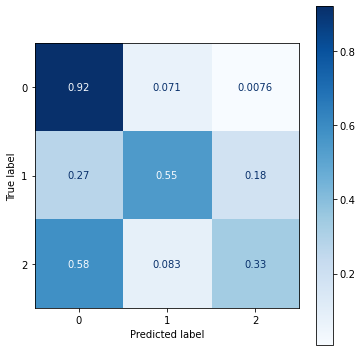

SVC(C=1, kernel='linear')

In [43]:
# tic = time() #timing!
svc_linear = SVC(kernel='linear',C=1)
fit_and_time_model(svc_linear,*train_test_list)

### RandomForest

[i] Training started at 05/16/21-17:43:10:
	Training time was 0.4385 seconds.

           Train  Test  Difference
accuracy    1.0  0.87        0.13 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       394
           1       0.58      0.56      0.57        66
           2       0.33      0.25      0.29        12

    accuracy                           0.87       472
   macro avg       0.61      0.58      0.60       472
weighted avg       0.86      0.87      0.87       472



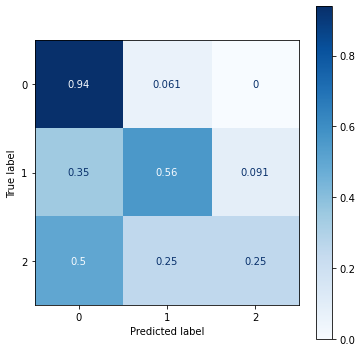

RandomForestClassifier()

In [44]:
rf = RandomForestClassifier()
fit_and_time_model(rf,*train_test_list)

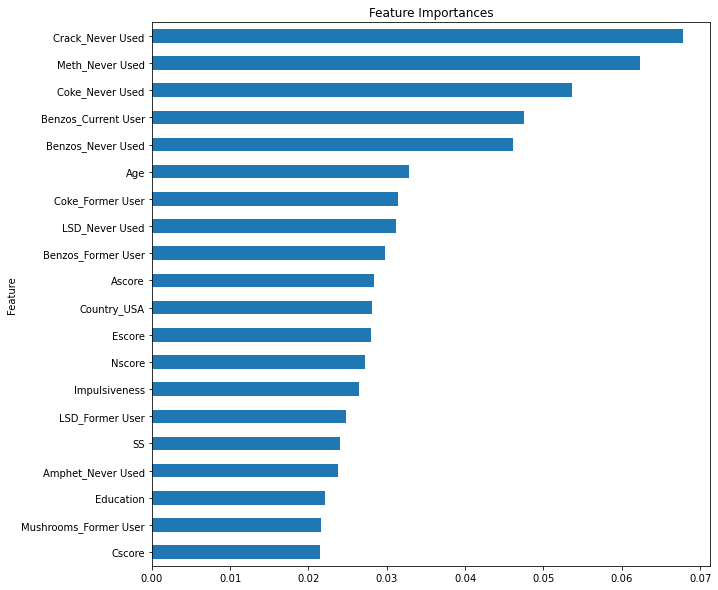

In [45]:
get_importance(rf,X_test_df);

## Using SHAP and Shapely Values for Model Interpretation




- White Paper on Shapely Values:
    - https://arxiv.org/abs/1705.07874
    
- Towards Data Science Blog Posts:
    - [Explain Your Model with SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

    - [Explain Any Model with SHAP KernelExplaibner](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)





- Videos/Talks:
    - ["Open the Black Box: an intro to Model Interpretability with LIME and SHAP](https://youtu.be/C80SQe16Rao)
    

### Using SHAP

- Uses game theory to explain feature importance and how a feature steered a model's prediction(s) by removing each feature and seeing the effect on the error.

- SHAP has:
    - `TreeExplainer`:
        - compatible with sckit learn, xgboost, Catboost
    - `KernelExplainer`:
        - compatible with "any" model
        


- See [this blog post](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) for intro to topic and how to use with trees

- For non-tree/random forest models [see this follow up post]( https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

        

### To Get Expanations for Trees:



- Import and initialize javascript:

```python
import shap 
shap.initjs()
```
1. Create a shap explainer using your fit model.

```python
explainer = shap.TreeExplainer(xgb_clf)
```

2. Get shapely values from explainer for your training data

```python
shap_values = explainer.shap_values(X_train,y_train)
```            

3. Select which type of the available plots you'd like to visualize

    
- **Types of Plots:**
    - `summary_plot()`
    - `dependence_plot()`
    - `force_plot()` for a given observation
    - `force_plot()` for all data
    
  

In [46]:
import shap 
print(shap.__version__)
shap.initjs()

0.37.0


In [47]:
## Initialize an explainer with the model
explainer = shap.TreeExplainer(rf)

## Calculaate shap values for test data
shap_values = explainer.shap_values(X_test_df,y_test)
len(shap_values)

3

In [48]:
shap_values[2]

array([[ 8.51237122e-03, -3.63907797e-03, -9.24751451e-03, ...,
         3.80298755e-05,  2.05625821e-04,  1.20177731e-03],
       [-1.60724116e-02,  4.00205751e-03, -4.20034274e-03, ...,
         4.00404655e-05, -1.49851204e-04,  5.59508385e-04],
       [ 7.23584238e-03, -1.05314321e-03,  2.94115821e-03, ...,
         4.55682487e-05,  1.73116965e-04,  3.61455981e-04],
       ...,
       [-2.15774558e-02, -8.05662894e-03, -6.50587793e-03, ...,
         4.62869675e-05, -1.55430890e-04,  1.23619102e-04],
       [-8.06939685e-03, -1.13338974e-02, -9.79969405e-03, ...,
         4.41546922e-05, -8.50973809e-05,  6.83332316e-04],
       [ 1.22920996e-02,  8.61047678e-03,  4.19763316e-03, ...,
         5.72013988e-05,  1.04599718e-03,  7.37710997e-04]])

### Summary Plot

```python
## For normal bar graph of importance:
shap.summary_plot(shap_values[1],X_train,plot_type='bar')

## For detail Shapely value visuals:
shap.summary_plot(shap_values, X_train)
```
  

**`shap.summary_plot`**
> - Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.


>- **IMPORTANT NOTE:** You may need to slice out the correct shap_values for the target class. (by default explainer.shap_values seems to return a list for a binary classification, one set of shap values for each class).
    - This will cause issues like the summary plot having a bar with an equal amount of blue and red for each class. 
    - To fix, slice out the correct matrix from shap_values [0,1]


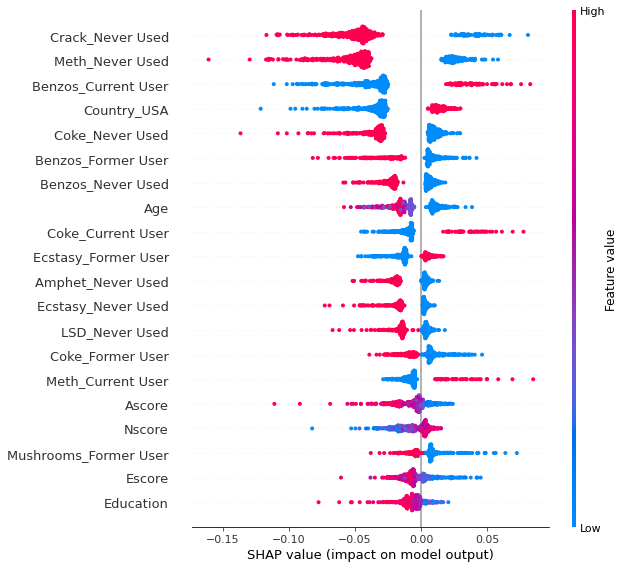

In [49]:
shap.summary_plot(shap_values[2],X_test_df)

### Force Plots

`shap.force_plot`

To show an individual data point's prediction and the factors pushing it towards one class or another

```python
## Just using np to randomly select a row
row = np.random.choice(range(len(X_train)))
                       
shap.force_plot(explainer.expected_value, shap_values[row,:], X_train.iloc[row,:])
```

In [50]:
## Overall Forceplot
shap.force_plot(explainer.expected_value[2], shap_values[2],X_test_df)       

#### Explain Individual Plot

In [51]:
row = np.random.choice(range(len(X_test_df)))
row

417

In [52]:
## Individual forceplot
shap.force_plot(explainer.expected_value[2], shap_values[2][row],X_test_df.iloc[row])       

**`shap.dependence_plot`**


```python
## To Auto-Select Feature Most correlated with a specific feature, just pass the desired feature's column name.

shap.dependence_plot('super_dist', shap_values, X_train)

## There is a way to specifically call out multiple features but I wasn't able to summarize it quickly for this nb
```

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


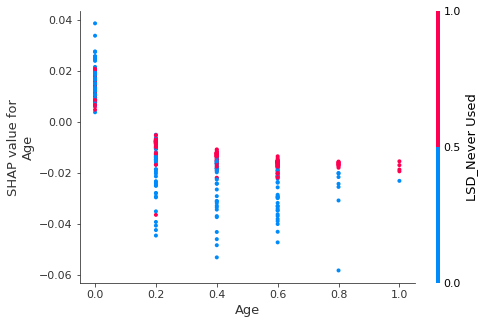

In [53]:
shap.dependence_plot('Age',shap_values[2],X_test_df)

### Using SHAP with SVMS: 

In [ ]:
stop

https://slundberg.github.io/shap/notebooks/Iris%20classification%20with%20scikit-learn.html**
- Must run the SVC with `probability=True` to be able to use `.predict_proba`, which is needed for the `KernelExplainer`

In [ ]:
svc_linear = fit_and_time_model(SVC(kernel='linear',probability=True,C=1),
                                *train_test_list)

In [ ]:
# pred_func = svc_linear.decision_function
X_shap = shap.sample(X_test_df,nsamples=100)
explainer = shap.KernelExplainer(svc_linear.predict_proba,X_shap)
explainer

In [ ]:
shap_values = explainer.shap_values(X_shap,nsamples=100)#, nsamples=1000)

In [ ]:
# # shap.force_plot(shap_values[0],X_test)
shap.summary_plot(explainer.expected_value[2], shap_values[2]) 

In [ ]:
# shap.summary_plot(shap_values,X_test,plot_type='bar')

### First: Linear Kernel